# 제품 이상여부 판별 프로젝트

## 1. 데이터 불러오기


### 필수 라이브러리


In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### 데이터 읽어오기


In [2]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test = pd.read_csv('./data/test.csv')
test

,Set ID,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,...,Production Qty Collect Result_Fill2,Production Qty Unit Time_Fill2,Production Qty Judge Value_Fill2,Receip No Collect Result_Fill2,Receip No Unit Time_Fill2,Receip No Judge Value_Fill2,WorkMode Collect Result_Fill2,WorkMode Unit Time_Fill2,WorkMode Judge Value_Fill2,target
0,0001be084fbc4aaa9d921f39e595961b,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3J1XF767-1,1,OK,1000.0,NaN,...,195,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
1,0005bbd180064abd99e63f9ed3e1ac80,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4B1XD472-2,1,OK,1000.0,NaN,...,14,NaN,NaN,256,NaN,NaN,1,NaN,NaN,NaN
2,000948934c4140d883d670adcb609584,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3H1XE355-1,1,OK,240.0,NaN,...,98,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
3,000a6bfd02874c6296dc7b2e9c5678a7,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3L1XA128-1,1,OK,1000.0,NaN,...,14,NaN,NaN,0,NaN,NaN,1,NaN,NaN,NaN
4,0018e78ce91343678716e2ea27a51c95,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4A1XA639-1,1,OK,240.0,NaN,...,1,NaN,NaN,215,NaN,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,ffea508b59934d689b540f95eb3fa730,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1XB597-1,1,OK,1000.0,NaN,...,14,NaN,NaN,131,NaN,NaN,1,NaN,NaN,NaN
17357,ffed8923c8a448a98afc641b770be153,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4A1XB974-1,1,OK,1000.0,NaN,...,12,NaN,NaN,279,NaN,NaN,1,NaN,NaN,NaN
17358,fff1e73734da40adbe805359b3efb462,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3L1XA998-1,1,OK,240.0,NaN,...,4,NaN,NaN,66,NaN,NaN,1,NaN,NaN,NaN
17359,fff8e38bdd09470baf95f71e92075dec,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1XC376-1,1,OK,240.0,NaN,...,117,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN


### 위치 이동한 데이터 복구시켜놓기

In [3]:
# divide
dam = train.filter(regex='_Dam')
fill1 = train.filter(regex='_Fill1')
fill2 = train.filter(regex='_Fill2')
autoclave = train.filter(regex='_AutoClave')

# dam
dam = dam.dropna(axis=1, how='all')
dam = dam.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam')
dam_mask = dam[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
dam.loc[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam.columns[24:]] = dam_mask
dam = dam.drop(columns='WorkMode Collect Result_Dam')

# fill1
fill1 = fill1.dropna(axis=1, how='all')
fill1 = fill1.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1')
fill1_mask = fill1[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan])].iloc[:, 14:].shift(-1, axis = 1).values
fill1.loc[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan]), fill1.columns[14:]] = fill1_mask
fill1 = fill1.drop(columns='WorkMode Collect Result_Fill1')

# fill2
fill2 = fill2.dropna(axis=1, how='all')
fill2 = fill2.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2')
fill2_mask = fill2[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
fill2.loc[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2.columns[24:]] = fill2_mask
fill2 = fill2.drop(columns='WorkMode Collect Result_Fill2')

/tmp/ipykernel_88/156678538.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.     0.012  0.    ...  0.    -0.019  0.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dam.loc[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam.columns[24:]] = dam_mask
/tmp/ipykernel_88/156678538.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[114.612 114.612  85.    ...  85.    114.612  85.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fill2.loc[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2.columns[24:]] = fill2_mask


In [4]:
# divide
dam_test = test.filter(regex='_Dam')
fill1_test = test.filter(regex='_Fill1')
fill2_test = test.filter(regex='_Fill2')
autoclave_test = test.filter(regex='_AutoClave')

# dam
dam_test = dam_test.dropna(axis=1, how='all')
dam_test = dam_test.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam')
dam_mask_test = dam_test[dam_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
dam_test.loc[dam_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam_test.columns[24:]] = dam_mask_test
dam_test = dam_test.drop(columns='WorkMode Collect Result_Dam')

# fill1
fill1_test = fill1_test.dropna(axis=1, how='all')
fill1_test = fill1_test.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1')
fill1_mask_test = fill1_test[fill1_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan])].iloc[:, 14:].shift(-1, axis = 1).values
fill1_test.loc[fill1_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan]), fill1_test.columns[14:]] = fill1_mask_test
fill1_test = fill1_test.drop(columns='WorkMode Collect Result_Fill1')

# fill2
fill2_test = fill2_test.dropna(axis=1, how='all')
fill2_test = fill2_test.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2')
fill2_mask_test = fill2_test[fill2_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
fill2_test.loc[fill2_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2_test.columns[24:]] = fill2_mask_test
fill2_test = fill2_test.drop(columns='WorkMode Collect Result_Fill2')

/tmp/ipykernel_88/2527669317.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.054  0.     0.    ...  0.     0.     0.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dam_test.loc[dam_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam_test.columns[24:]] = dam_mask_test
/tmp/ipykernel_88/2527669317.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[85. 85. 85. ... 85. 85. 85.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fill2_test.loc[fill2_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2_test.columns[24:]] = fill2_mask_test


In [5]:
# 변수 이름에서 Collect Result 빼기
dam.columns = dam.columns.str.replace(' Collect Result', '')
fill1.columns = fill1.columns.str.replace(' Collect Result', '')
fill2.columns = fill2.columns.str.replace(' Collect Result', '')
autoclave.columns = autoclave.columns.str.replace(' Collect Result', '')

In [6]:
# 변수 이름에서 Collect Result 빼기
dam_test.columns = dam_test.columns.str.replace(' Collect Result', '')
fill1_test.columns = fill1_test.columns.str.replace(' Collect Result', '')
fill2_test.columns = fill2_test.columns.str.replace(' Collect Result', '')
autoclave_test.columns = autoclave_test.columns.str.replace(' Collect Result', '')

In [7]:
# 각 데이터에 판정 붙여넣기
dam['target'] = train['target']
fill1['target'] = train['target']
fill2['target'] = train['target']
autoclave['target'] = train['target']

/tmp/ipykernel_88/3168020836.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autoclave['target'] = train['target']


In [8]:
dam.columns

Index(['Wip Line_Dam', 'Process Desc._Dam', 'Equipment_Dam',
       'Model.Suffix_Dam', 'Workorder_Dam', 'Insp. Seq No._Dam',
       'Insp Judge Code_Dam', 'CURE END POSITION X_Dam',
       'CURE END POSITION Z_Dam', 'CURE END POSITION Θ_Dam', 'CURE SPEED_Dam',
       'CURE STANDBY POSITION X_Dam', 'CURE STANDBY POSITION Z_Dam',
       'CURE STANDBY POSITION Θ_Dam', 'CURE START POSITION X_Dam',
       'CURE START POSITION Z_Dam', 'CURE START POSITION Θ_Dam',
       'DISCHARGED SPEED OF RESIN_Dam', 'DISCHARGED TIME OF RESIN(Stage1)_Dam',
       'DISCHARGED TIME OF RESIN(Stage2)_Dam',
       'DISCHARGED TIME OF RESIN(Stage3)_Dam', 'Dispense Volume(Stage1)_Dam',
       'Dispense Volume(Stage2)_Dam', 'Dispense Volume(Stage3)_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage1)_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage2)_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage3)_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1)_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2)_Dam',
   

In [44]:
# row 생략 없이 출력
pd.set_option('display.max_rows', None)

# col 생략 없이 출력
pd.set_option('display.max_columns', None)

In [10]:
dam[['CURE END POSITION X_Dam',
       'CURE END POSITION Z_Dam', 'CURE END POSITION Θ_Dam',
       'CURE STANDBY POSITION X_Dam', 'CURE STANDBY POSITION Z_Dam',
       'CURE STANDBY POSITION Θ_Dam', 'CURE START POSITION X_Dam',
       'CURE START POSITION Z_Dam', 'CURE START POSITION Θ_Dam']].drop_duplicates()

,CURE END POSITION X_Dam,CURE END POSITION Z_Dam,CURE END POSITION Θ_Dam,CURE STANDBY POSITION X_Dam,CURE STANDBY POSITION Z_Dam,CURE STANDBY POSITION Θ_Dam,CURE START POSITION X_Dam,CURE START POSITION Z_Dam,CURE START POSITION Θ_Dam
0,240.0,2.5,-90,1150,33.5,0,1030,33.5,-90
2,1000.0,12.5,90,1150,33.5,0,280,33.5,90


In [11]:
dam_test[['CURE END POSITION X_Dam',
       'CURE END POSITION Z_Dam', 'CURE END POSITION Θ_Dam',
       'CURE STANDBY POSITION X_Dam', 'CURE STANDBY POSITION Z_Dam',
       'CURE STANDBY POSITION Θ_Dam', 'CURE START POSITION X_Dam',
       'CURE START POSITION Z_Dam', 'CURE START POSITION Θ_Dam']].drop_duplicates()

,CURE END POSITION X_Dam,CURE END POSITION Z_Dam,CURE END POSITION Θ_Dam,CURE STANDBY POSITION X_Dam,CURE STANDBY POSITION Z_Dam,CURE STANDBY POSITION Θ_Dam,CURE START POSITION X_Dam,CURE START POSITION Z_Dam,CURE START POSITION Θ_Dam
0,1000.0,12.5,90,1150,33.5,0,280,33.5,90
2,240.0,2.5,-90,1150,33.5,0,1030,33.5,-90


#### 알 수 있는 것
- 다음과 같이 두 가지 패턴으로 분류가 가능 
- 9개의 변수를 단 두개로 축소할 수 있음
- 경화의 지정 값이라 명할 수 있음

In [12]:
dam[['HEAD Standby Position X_Dam', 'HEAD Standby Position Y_Dam',
       'HEAD Standby Position Z_Dam', 'Head Clean Position X_Dam',
       'Head Clean Position Y_Dam', 'Head Clean Position Z_Dam',
       'Head Purge Position X_Dam', 'Head Purge Position Y_Dam',
       'Head Purge Position Z_Dam', 'Head Zero Position X_Dam',
       'Head Zero Position Y_Dam', 'Head Zero Position Z_Dam',]].drop_duplicates()

,HEAD Standby Position X_Dam,HEAD Standby Position Y_Dam,HEAD Standby Position Z_Dam,Head Clean Position X_Dam,Head Clean Position Y_Dam,Head Clean Position Z_Dam,Head Purge Position X_Dam,Head Purge Position Y_Dam,Head Purge Position Z_Dam,Head Zero Position X_Dam,Head Zero Position Y_Dam,Head Zero Position Z_Dam
0,257.0,66,0,127.5,66.0,124.00,257.0,66,130.85,505.0,300.0,265.00
1,257.0,66,0,127.5,66.0,130.85,257.0,66,130.85,505.0,300.0,265.00
2,257.0,66,0,127.5,66.0,124.00,257.0,66,130.85,505.0,300.0,265.02
4,257.0,66,0,127.5,66.0,133.50,257.0,66,133.50,505.0,300.0,265.00
5,257.0,66,0,127.5,66.0,133.50,257.0,66,133.50,505.0,303.5,265.00
6,257.0,66,0,127.5,66.0,130.85,257.0,66,130.85,505.0,300.0,265.02
127,257.0,66,0,127.5,66.0,124.50,257.0,66,124.50,505.0,303.5,265.00
562,257.0,66,0,127.5,66.0,118.85,257.0,66,130.85,505.0,300.0,265.02
1432,257.0,66,0,127.5,66.0,130.85,257.0,66,130.85,505.0,303.5,265.00
6308,257.0,66,0,127.5,66.0,130.85,257.0,66,133.50,505.0,300.0,265.00


In [13]:
dam_test[['HEAD Standby Position X_Dam', 'HEAD Standby Position Y_Dam',
       'HEAD Standby Position Z_Dam', 'Head Clean Position X_Dam',
       'Head Clean Position Y_Dam', 'Head Clean Position Z_Dam',
       'Head Purge Position X_Dam', 'Head Purge Position Y_Dam',
       'Head Purge Position Z_Dam', 'Head Zero Position X_Dam',
       'Head Zero Position Y_Dam', 'Head Zero Position Z_Dam',]].drop_duplicates()

,HEAD Standby Position X_Dam,HEAD Standby Position Y_Dam,HEAD Standby Position Z_Dam,Head Clean Position X_Dam,Head Clean Position Y_Dam,Head Clean Position Z_Dam,Head Purge Position X_Dam,Head Purge Position Y_Dam,Head Purge Position Z_Dam,Head Zero Position X_Dam,Head Zero Position Y_Dam,Head Zero Position Z_Dam
0,257.0,66,0,127.5,66.0,130.85,257.0,66,130.85,505.0,300.0,265.00
1,257.0,66,0,127.5,66.0,124.00,257.0,66,130.85,505.0,300.0,265.02
2,257.0,66,0,127.5,66.0,133.50,257.0,66,133.50,505.0,300.0,265.00
4,257.0,66,0,127.5,66.0,130.85,257.0,66,130.85,505.0,300.0,265.02
5,257.0,66,0,127.5,66.0,133.50,257.0,66,133.50,505.0,303.5,265.00
22,257.0,66,0,127.5,66.0,124.00,257.0,66,130.85,505.0,300.0,265.00
59,257.0,66,0,127.5,66.0,124.50,257.0,66,124.50,505.0,303.5,265.00
162,257.0,66,0,127.5,66.0,118.85,257.0,66,130.85,505.0,300.0,265.02
210,257.0,66,0,127.5,66.0,130.85,257.0,66,130.85,505.0,303.5,265.00
1525,257.0,66,0,127.5,66.0,130.85,257.0,66,133.50,505.0,300.0,265.00


In [14]:
tmp = dam[['Head Clean Position Z_Dam', 'Head Purge Position Z_Dam', 'target']]
tmp['diff'] = tmp['Head Clean Position Z_Dam'] - tmp['Head Purge Position Z_Dam']
pd.crosstab([tmp['Head Clean Position Z_Dam'], tmp['Head Purge Position Z_Dam']], tmp['target'])

/tmp/ipykernel_88/219224890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['diff'] = tmp['Head Clean Position Z_Dam'] - tmp['Head Purge Position Z_Dam']


target                                               AbNormal  Normal
Head Clean Position Z_Dam Head Purge Position Z_Dam                  
118.85                    130.85                            0      33
124.00                    130.85                          403    8090
124.50                    124.50                           28     303
130.85                    130.85                         1183   22220
                          133.50                            2      13
133.50                    133.50                          734    7497

In [15]:
pd.crosstab(tmp['diff'], tmp['target'])

target,AbNormal,Normal
diff,,
-12.00,0,33
-6.85,403,8090
-2.65,2,13
0.00,1945,30020


In [16]:
pd.crosstab(tmp['Head Purge Position Z_Dam'], tmp['target'])

target,AbNormal,Normal
Head Purge Position Z_Dam,,
124.50,28,303
130.85,1586,30343
133.50,736,7510


#### 알 수 있는것
- clean, purge 위치 차이로 품질 차이가 존재하는 것은 아니다

In [17]:
autoclave

,Wip Line_AutoClave,Process Desc._AutoClave,Equipment_AutoClave,Model.Suffix_AutoClave,Workorder_AutoClave,Insp. Seq No._AutoClave,Insp Judge Code_AutoClave,1st Pressure_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,1st Pressure Judge Value_AutoClave,2nd Pressure_AutoClave,2nd Pressure Unit Time_AutoClave,2nd Pressure Judge Value_AutoClave,3rd Pressure_AutoClave,3rd Pressure Unit Time_AutoClave,3rd Pressure Judge Value_AutoClave,Chamber Temp._AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave,target
0,IVI-OB6,Auto Clave Out,Auto Clave Out,AJX75334505,4F1XA938-1,1,OK,0.312,240,OK,0.493,1,OK,0.499,120,OK,54,361,OK,NaN,NaN,NaN,Normal
1,IVI-OB6,Auto Clave Out,Auto Clave Out,AJX75334505,3KPM0016-2,1,OK,0.311,241,OK,0.311,121,OK,0.498,121,OK,54,483,OK,NaN,NaN,NaN,Normal
2,IVI-OB6,Auto Clave Out,Auto Clave Out,AJX75334501,4E1X9167-1,1,OK,0.315,241,OK,0.490,1,OK,0.498,121,OK,56,363,OK,OK,NaN,OK,Normal
3,IVI-OB6,Auto Clave Out,Auto Clave Out,AJX75334501,3K1X0057-1,1,OK,0.299,241,OK,0.300,121,OK,0.500,121,OK,54,483,OK,NaN,NaN,NaN,Normal
4,IVI-OB6,Auto Clave Out,Auto Clave Out,AJX75334501,3HPM0007-1,1,OK,0.302,240,OK,0.302,120,OK,0.498,120,OK,47,480,NG,NaN,NaN,NaN,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Auto Clave Out,Auto Clave Out,AJX75334501,3J1XF434-2,1,OK,0.300,241,OK,0.300,121,OK,0.500,121,OK,54,483,OK,NaN,NaN,NaN,Normal
40502,IVI-OB6,Auto Clave Out,Auto Clave Out,AJX75334501,4E1XC796-1,1,OK,0.305,240,OK,0.493,1,OK,0.498,120,OK,49,361,NG,NaN,NaN,NaN,Normal
40503,IVI-OB6,Auto Clave Out,Auto Clave Out,AJX75334501,4C1XD438-1,1,OK,0.309,241,OK,0.490,1,OK,0.498,121,OK,48,363,NG,OK,NaN,OK,Normal
40504,IVI-OB6,Auto Clave Out,Auto Clave Out,AJX75334501,3I1XA258-1,1,OK,0.302,241,OK,0.303,121,OK,0.499,121,OK,54,483,OK,NaN,NaN,NaN,Normal


In [18]:
pd.crosstab(autoclave['Chamber Temp. Unit Time_AutoClave'], autoclave['target'])

target,AbNormal,Normal
Chamber Temp. Unit Time_AutoClave,,
3,0,4
61,2,0
121,0,1
180,6,0
183,13,0
212,12,12
242,3,3
243,0,9
300,3,11


In [19]:
pd.crosstab([autoclave['1st Pressure 1st Pressure Unit Time_AutoClave'], autoclave['2nd Pressure Unit Time_AutoClave'], autoclave['3rd Pressure Unit Time_AutoClave']], autoclave['target'])

target                                                                                                           AbNormal  \
1st Pressure 1st Pressure Unit Time_AutoClave 2nd Pressure Unit Time_AutoClave 3rd Pressure Unit Time_AutoClave             
0                                             1                                60                                       2   
                                              61                               60                                       0   
                                              181                              120                                      4   
1                                             1                                1                                        0   
                                                                               241                                      0   
                                                                               301                                      0   
                                              121                              121                                      0   
                                              181                              181                                      0   
60                                            60                               60                                       6   
                                              120                              120                                      2   
                                                                               180                                      2   
61                                            61                               61                                      13   
                                              90                               61                                      12   
                                              121                              121                                      1   
180                                           60                               60                                       1   
                                              120                              180                                     11   
                                              180                              120                                      1   
181                                           1                                181                                      9   
240                                           0                                120                                      7   
                                              1                                1                                        3   
                                                                               120                                    198   
                                                                               121                                      1   
                                              90                               120                                      9   
                                              120                              120                                    348   
241                                           1                                120                                     24   
                                                                               121                                    699   
                                              61                               121                                      0   
                                              90                               121                                     59   
                                              120                              120                                     26   
                                              121                              121                                    586   


#### 알 수 있는 것
- 여기선 전혀 모르겠다.

In [20]:
tmp = pd.DataFrame(dam['Machine Tact time_Dam'])
tmp['target'] = train['target']
tmp['Machine Tact time_Fill1'] = fill1['Machine Tact time_Fill1']
tmp['Machine Tact time_Fill2'] = fill2['Machine Tact time_Fill2']
tmp

,Machine Tact time_Dam,target,Machine Tact time_Fill1,Machine Tact time_Fill2
0,58.5,Normal,55.7,19.9
1,65.1,Normal,56.5,19.6
2,76.9,Normal,58.7,19.8
3,70.5,Normal,57.7,19.9
4,88.3,Normal,89.9,19.7
...,...,...,...,...
40501,56.7,Normal,51.8,19.2
40502,78.5,Normal,58.7,20.5
40503,69.5,Normal,56.2,19.7
40504,57.7,Normal,57.4,20.1


In [33]:
fill2[['CURE END POSITION X_Fill2',
       'CURE END POSITION Z_Fill2', 'CURE END POSITION Θ_Fill2',
       'CURE STANDBY POSITION X_Fill2', 'CURE STANDBY POSITION Z_Fill2',
       'CURE STANDBY POSITION Θ_Fill2', 'CURE START POSITION X_Fill2',
       'CURE START POSITION Z_Fill2', 'CURE START POSITION Θ_Fill2']].drop_duplicates()

,CURE END POSITION X_Fill2,CURE END POSITION Z_Fill2,CURE END POSITION Θ_Fill2,CURE STANDBY POSITION X_Fill2,CURE STANDBY POSITION Z_Fill2,CURE STANDBY POSITION Θ_Fill2,CURE START POSITION X_Fill2,CURE START POSITION Z_Fill2,CURE START POSITION Θ_Fill2
0,240,33,-90,1020,33,0,1020,33,90
4,240,32,-90,1020,33,0,1020,33,90
5,240,32,-90,1020,32,0,1020,32,90
24,240,22,-90,1020,22,0,1020,22,90
27,240,33,-90,1020,32,0,1020,32,90
41,240,32,-90,1020,22,0,1020,22,90
240,240,33,-90,1020,23,0,1020,23,90
569,1020,33,-90,1020,33,0,240,33,90
5801,240,22,-90,1020,33,0,1020,33,90


In [32]:
fill2_test[['CURE END POSITION X_Fill2',
       'CURE END POSITION Z_Fill2', 'CURE END POSITION Θ_Fill2',
       'CURE STANDBY POSITION X_Fill2', 'CURE STANDBY POSITION Z_Fill2',
       'CURE STANDBY POSITION Θ_Fill2', 'CURE START POSITION X_Fill2',
       'CURE START POSITION Z_Fill2', 'CURE START POSITION Θ_Fill2']].drop_duplicates()

,CURE END POSITION X_Fill2,CURE END POSITION Z_Fill2,CURE END POSITION Θ_Fill2,CURE STANDBY POSITION X_Fill2,CURE STANDBY POSITION Z_Fill2,CURE STANDBY POSITION Θ_Fill2,CURE START POSITION X_Fill2,CURE START POSITION Z_Fill2,CURE START POSITION Θ_Fill2
0,240,33,-90,1020,33,0,1020,33,90
2,240,33,-90,1020,23,0,1020,23,90
5,240,32,-90,1020,32,0,1020,32,90
6,240,32,-90,1020,33,0,1020,33,90
25,240,33,-90,1020,32,0,1020,32,90
64,240,32,-90,1020,22,0,1020,22,90
128,240,22,-90,1020,22,0,1020,22,90
183,1020,33,-90,1020,33,0,240,33,90


In [37]:
fill2.groupby(['CURE END POSITION X_Fill2',
       'CURE END POSITION Z_Fill2', 'CURE END POSITION Θ_Fill2', 'CURE START POSITION X_Fill2',
       'CURE START POSITION Z_Fill2', 'CURE START POSITION Θ_Fill2', 'target']).count()

Wip Line_Fill2  \
CURE END POSITION X_Fill2 CURE END POSITION Z_Fill2 CURE END POSITION Θ_Fill2 CURE START POSITION X_Fill2 CURE START POSITION Z_Fill2 CURE START POSITION Θ_Fill2 target                     
240                       22                        -90                       1020                        22                          90                          AbNormal               5   
                                                                                                                                                                  Normal                90   
                                                                                                          33                          90                          Normal                 1   
                          32                        -90                       1020                        22                          90                          AbNormal              29   
                                                                                                                                                                  Normal               345   
                                                                                                          32                          90                          AbNormal             367   
                                                                                                                                                                  Normal              3540   
                                                                                                          33                          90                          AbNormal             255   
                                                                                                                                                                  Normal              2761   
                          33                        -90                       1020                        23                          90                          AbNormal              22   
                                                                                                                                                                  Normal               182   
                                                                                                          32                          90                          AbNormal              54   
                                                                                                                                                                  Normal               942   
                                                                                                          33                          90                          AbNormal            1610   
                                                                                                                                                                  Normal             30171   
1020                      33                        -90                       240                         33                          90                          AbNormal               8   
                                                                                                                                                                  Normal               124   

                                                                                                                                                                            Process Desc._Fill2  \
CURE END POSITION X_Fill2 CURE END POSITION Z_Fill2 CURE END POSITION Θ_Fill2 CURE START POSITION X_Fill2 CURE START POSITION Z_Fill2 CURE START POSITION Θ_Fill2 target                          
240                       22                        -90                       1020                        22                          90                          AbNormal 

In [45]:
dam.groupby([
    'Receip No_Dam', 'Stage1 Circle1 Distance Speed_Dam',
       'Stage1 Circle2 Distance Speed_Dam',
       'Stage1 Circle3 Distance Speed_Dam',
       'Stage1 Circle4 Distance Speed_Dam', 'Stage1 Line1 Distance Speed_Dam',
       'Stage1 Line2 Distance Speed_Dam', 'Stage1 Line3 Distance Speed_Dam',
       'Stage1 Line4 Distance Speed_Dam', 'Stage2 Circle1 Distance Speed_Dam',
       'Stage2 Circle2 Distance Speed_Dam',
       'Stage2 Circle3 Distance Speed_Dam',
       'Stage2 Circle4 Distance Speed_Dam', 'Stage2 Line1 Distance Speed_Dam',
       'Stage2 Line2 Distance Speed_Dam', 'Stage2 Line3 Distance Speed_Dam',
       'Stage2 Line4 Distance Speed_Dam', 'Stage3 Circle1 Distance Speed_Dam',
       'Stage3 Circle2 Distance Speed_Dam',
       'Stage3 Circle3 Distance Speed_Dam',
       'Stage3 Circle4 Distance Speed_Dam', 'Stage3 Line1 Distance Speed_Dam',
       'Stage3 Line2 Distance Speed_Dam', 'Stage3 Line3 Distance Speed_Dam',
       'Stage3 Line4 Distance Speed_Dam', 'target'
]).count()

Wip Line_Dam  \
Receip No_Dam Stage1 Circle1 Distance Speed_Dam Stage1 Circle2 Distance Speed_Dam Stage1 Circle3 Distance Speed_Dam Stage1 Circle4 Distance Speed_Dam Stage1 Line1 Distance Speed_Dam Stage1 Line2 Distance Speed_Dam Stage1 Line3 Distance Speed_Dam Stage1 Line4 Distance Speed_Dam Stage2 Circle1 Distance Speed_Dam Stage2 Circle2 Distance Speed_Dam Stage2 Circle3 Distance Speed_Dam Stage2 Circle4 Distance Speed_Dam Stage2 Line1 Distance Speed_Dam Stage2 Line2 Distance Speed_Dam Stage2 Line3 Distance Speed_Dam Stage2 Line4 Distance Speed_Dam Stage3 Circle1 Distance Speed_Dam Stage3 Circle2 Distance Speed_Dam Stage3 Circle3 Distance Speed_Dam Stage3 Circle4 Distance Speed_Dam Stage3 Line1 Distance Speed_Dam Stage3 Line2 Distance Speed_Dam Stage3 Line3 Distance Speed_Dam Stage3 Line4 Distance Speed_Dam target                   
1             4000                              4000                              4000                              4000                              4000                            4000                            4000                            4000                            4000                              4000                              4000                              4000                              4000                            4000                            4000                            4000                            4000                              4000                              4000                              4000                              4000                            4000                            4000                            4000                            AbNormal           121   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Normal            3823   
                                                                                                                                                                                                                                                                                      5000                              5000                              5000                              5000                              5000                            5000                            5000                            5000                            4000                              4000                              4000                              4000                              4000                            4000                            4000                            4000                            AbNormal            57   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [21]:
import seaborn as sns

<Axes: xlabel='Machine Tact time_Dam', ylabel='Machine Tact time_Fill1'>

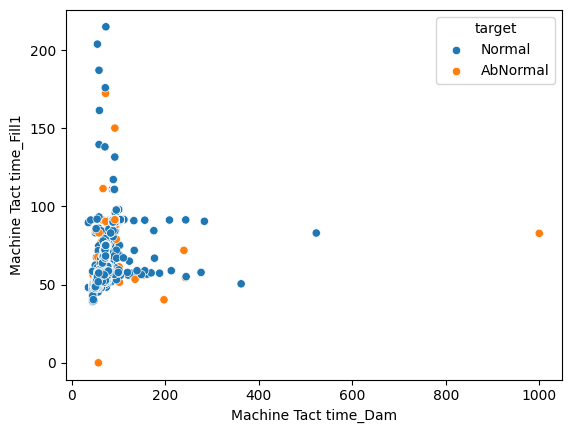

In [22]:
sns.scatterplot(data = tmp, x = 'Machine Tact time_Dam', y = 'Machine Tact time_Fill1', hue = 'target')

<Axes: xlabel='Machine Tact time_Dam', ylabel='Machine Tact time_Fill2'>

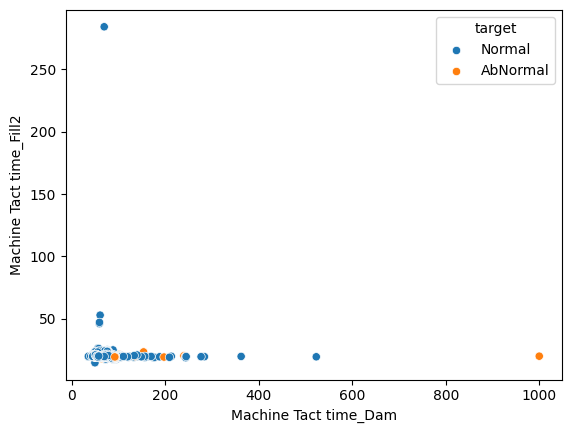

In [23]:
sns.scatterplot(data = tmp, x = 'Machine Tact time_Dam', y = 'Machine Tact time_Fill2', hue = 'target')

<Axes: xlabel='Machine Tact time_Fill1', ylabel='Machine Tact time_Fill2'>

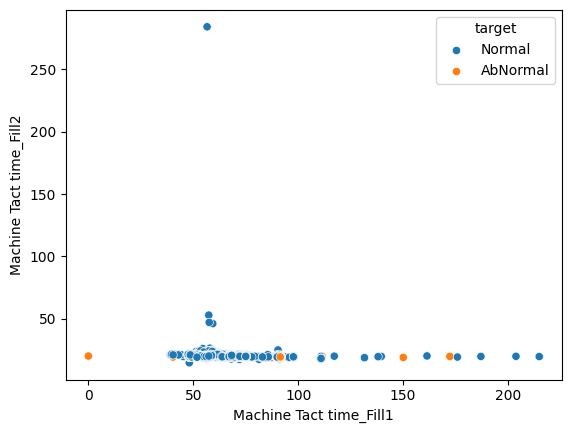

In [24]:
sns.scatterplot(data = tmp, x = 'Machine Tact time_Fill1', y = 'Machine Tact time_Fill2', hue = 'target')

<Axes: xlabel='Machine Tact time_Dam'>

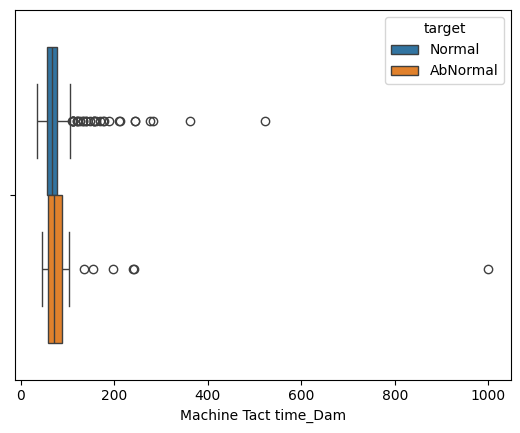

In [25]:
sns.boxplot(data = tmp, x = 'Machine Tact time_Dam', hue = 'target')

<Axes: xlabel='Machine Tact time_Fill1'>

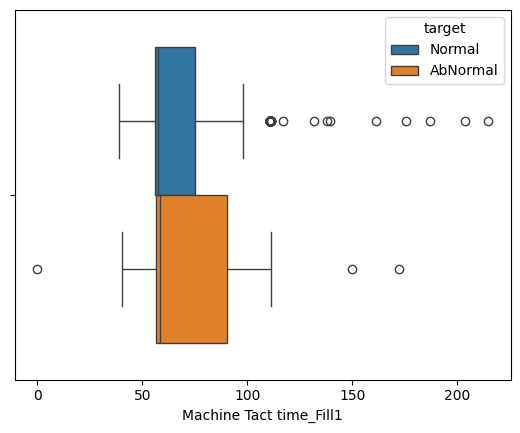

In [26]:
sns.boxplot(data = tmp, x = 'Machine Tact time_Fill1', hue = 'target')

<Axes: xlabel='Machine Tact time_Fill2'>

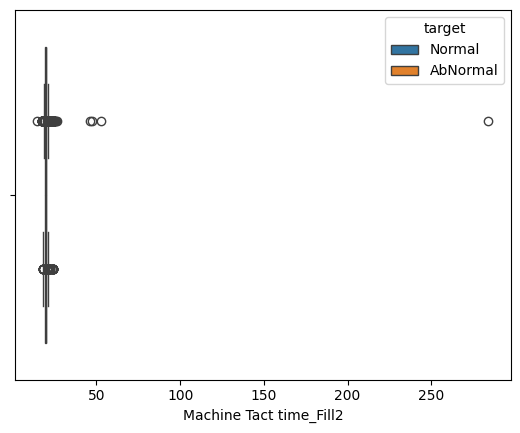

In [27]:
sns.boxplot(data = tmp, x = 'Machine Tact time_Fill2', hue = 'target')

In [28]:
# col 생략 없이 출력
pd.set_option('display.max_columns', 21)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**